<a href="https://colab.research.google.com/github/Chihiro-n/stockmodel/blob/master/LSTM_Stock_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NNで株価を予測モデルを作成する
rev2:入力データを一次元に限定

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# LSTMモデルを組む

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
%ls

 Check_Sinwave_LSTM_Stock_Classify.ipynb
'Colaboratory へようこそ のコピー'
 data/
 data_dir/
 DogCat.ipynb
 kaggleデータinputの方法DogCat.ipynb
 keras_ssd_hands-on/
 LSTM_changed_dataset.ipynb
'LSTM_Stock_Classify (1).ipynb'
 LSTM_Stock_Classify.ipynb
'LSTM_Stock_Regression (1).ipynb'
 LSTM_Stock_Regression.ipynb
 net.ckpt
 prophet/
'PyTorch実践入門ハンズオンセミナー配布用 のコピー'
 RNN_shapeCheak.ipynb
 RNN_sin_pred.ipynb
 sampleSubmission.csv
 StockRegression.ckpt
 torch_tuto_CFIA10.ipynb
 Youtube_Analysis_1.ipynb


# GPUセットのためのおまじない

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データセットを作る
### PytorchのLSTMに学習させるためのデータは次元の工夫が必要であり、二重リストにしないとエラーになる
### 訓練用とテスト用にデータを分ける。まず二重リストであるtmpを作ってからそれを分割した

In [ ]:
window = 10       # データは日足
target_term = 1   # 入力データに対して予測する日までの期間。
input_dim = 4

#csvfile = open('/content/drive/My Drive/data-text.csv', 'r', encoding='utf-8')
#df_train_law = pd.read_csv('./data/stock/label_difflog_2005-2018.csv' ,index_col=0)
df_train_law = pd.read_csv('./data/stock/class_label_difflog_2005-2018.csv' ,index_col=0)

df_train_law.head()

inp_dim = len(df_train_law)

train_endindex = int(inp_dim*0.9)



In [ ]:
print(df_train_law.head())

              始値    高値    安値    終値  ...  label_m0  label_p0  label_p1  label_class
日付                                  ...                                           
2005-01-05  4210  4220  4140  4150  ...       0.0       0.0       0.0          0.0
2005-01-06  4150  4210  4150  4190  ...       1.0       0.0       0.0          2.0
2005-01-07  4210  4210  4140  4150  ...       0.0       1.0       0.0          3.0
2005-01-11  4180  4210  4170  4200  ...       1.0       0.0       0.0          2.0
2005-01-12  4180  4190  4140  4150  ...       0.0       1.0       0.0          3.0

[5 rows x 17 columns]


### inputデータとして、株価をlogに加工した値のみを取り出す。
最初の行だけは削除しておく。階差をlabelとしているため

In [ ]:
if input_dim == 4:

  df_input = df_train_law.iloc[:, 4:8 ]   # 次元が4つの場合
elif input_dim ==1:
  df_input = df_train_law.iloc[:, 4 ]      # 次元を始値に限定する場合

#nd_cast = open.astype(np.float32)

In [ ]:
df_input = df_input.drop('2005-01-05', axis=0)

In [ ]:
df_input

,log始値,log高値,log安値,log終値
日付,,,,
2005-01-06,8.330864,8.345218,8.330864,8.340456
2005-01-07,8.345218,8.345218,8.328451,8.330864
2005-01-11,8.338067,8.345218,8.335671,8.342840
2005-01-12,8.338067,8.340456,8.328451,8.330864
2005-01-13,8.321178,8.328451,8.318742,8.323608
...,...,...,...,...
2018-12-21,8.777864,8.779096,8.764210,8.766550
2018-12-25,8.728264,8.733272,8.708805,8.712595
2018-12-26,8.720787,8.737934,8.706987,8.723557


## 念の為、inputdataを確認しておく

In [ ]:
# 
#plt.figure()
#plt.plot(df_input,label="loss")
#plt.legend()
#plt.grid()

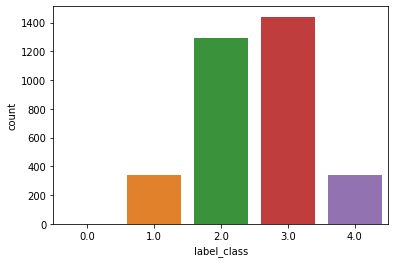

In [ ]:
sns.countplot(x="label_class", data=df_train_law)
plt.show()

### inputデータを作成する。
説明変数4つ　が 50日分.  
ループは50を引いておく  
numpyに変更しておく

In [ ]:
#train_input = np.array([])
train_input = []
train_t = []

for i in range(len(df_input)-window):
  #train_input = np.append( train_input, df_input.iloc[i: i+window] )
  train_input.append( df_input.iloc[i: i+window].values )

### 中身チェック

In [ ]:
print(len(train_input))
print(type(train_input))
#train_input[0]
#print(train_input.shape)


3406
<class 'list'>


### numpyに変更し、サイズもチェック

In [ ]:
np_train_input = np.array(train_input)
np_train_input = np_train_input.astype(np.float32)  ### float型に変更しておかないと、modelに入力する際にerrorが出る　※doubleはNG

print(np_train_input.shape)

np_train_input


(3406, 10, 4)


array([[[8.330864 , 8.345218 , 8.330864 , 8.340456 ],
        [8.345218 , 8.345218 , 8.328451 , 8.330864 ],
        [8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        ...,
        [8.328451 , 8.330864 , 8.3163   , 8.321178 ],
        [8.323608 , 8.328451 , 8.3163   , 8.3163   ],
        [8.3113985, 8.313852 , 8.301521 , 8.304    ]],

       [[8.345218 , 8.345218 , 8.328451 , 8.330864 ],
        [8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        [8.338066 , 8.340456 , 8.328451 , 8.330864 ],
        ...,
        [8.323608 , 8.328451 , 8.3163   , 8.3163   ],
        [8.3113985, 8.313852 , 8.301521 , 8.304    ],
        [8.304    , 8.313852 , 8.301521 , 8.308938 ]],

       [[8.338066 , 8.345218 , 8.335671 , 8.34284  ],
        [8.338066 , 8.340456 , 8.328451 , 8.330864 ],
        [8.321178 , 8.328451 , 8.318742 , 8.323608 ],
        ...,
        [8.3113985, 8.313852 , 8.301521 , 8.304    ],
        [8.304    , 8.313852 , 8.301521 , 8.308938 ],
        [8.306472 , 8.308938 , 8.301521

## input次元が1のときだけ必要になる。shapeを( len , timestep , 1 )にするため。
※reshapeをしない場合は(len , timestep)だけとなってエラーになる

In [ ]:
np_train_input = np_train_input.reshape(-1,window,input_dim)
print(np_train_input.shape)

(3406, 10, 4)


# labelデータも numpyに変更しておく
labalはonehot vectorなので、(3366,1,4)になるはず -> X ※pytorchのクロスエントロピーロスはエントロピーロスはonehotvectorに対応しておらずクラスラベルにする

In [ ]:
df_label = df_train_law.iloc[:, 4 ]
df_label

日付
2005-01-05    8.345218
2005-01-06    8.330864
2005-01-07    8.345218
2005-01-11    8.338067
2005-01-12    8.338067
                ...   
2018-12-21    8.777864
2018-12-25    8.728264
2018-12-26    8.720787
2018-12-27    8.763115
2018-12-28    8.758570
Name: log始値, Length: 3417, dtype: float64

In [ ]:
df_label = df_label.drop('2005-01-05', axis=0)

In [ ]:
type(df_label)

pandas.core.series.Series

In [ ]:
train_label = []

for i in range(len(df_label)-window):
  #train_label.append( df_label.iloc[window + i].values )
  train_label.append( df_label.iloc[window + i] )

In [ ]:
np_train_label = np.array(train_label)


np_train_label = np_train_label.astype(np.float32)
np_train_label.shape


(3406,)

## Shapeを変更する、 二重リストの型へ


In [ ]:
np_train_label = np_train_label.reshape(-1,1,1)

In [ ]:
print(np_train_label.shape)
print(np_train_label)


(3406, 1, 1)
[[[8.304   ]]

 [[8.306472]]

 [[8.296547]]

 ...

 [[8.720787]]

 [[8.763115]]

 [[8.75857 ]]]


## TrainとTestで分割する

In [ ]:
X_train, y_train, X_test, y_test= [], [], [], []


all_length = len(np_train_label)
train_length = int(all_length*0.9)

### 訓練用データセットを作成するループ
X_train = np_train_input[:train_length]
y_train = np_train_label[:train_length]

### テスト用データセットを作成するループ
X_test = np_train_input[train_length:]
y_test = np_train_label[train_length:]


In [ ]:

print(inp_dim)
print( len(X_train[0]) )
print( len(X_train) )

print(X_train[0])
print(X_train[1])
print(X_train[2])

print("=================")
print(y_train[0])
print(y_train[1])

print("=================")
print( len(X_test[0]) )
print( len(X_test) )

print(X_test[0])
print(X_test[1])
print(X_test[2])
print("=================")
print(y_test[0])
print(y_test[1])

3417
10
3065
[[8.330864  8.345218  8.330864  8.340456 ]
 [8.345218  8.345218  8.328451  8.330864 ]
 [8.338066  8.345218  8.335671  8.34284  ]
 [8.338066  8.340456  8.328451  8.330864 ]
 [8.321178  8.328451  8.318742  8.323608 ]
 [8.318742  8.335671  8.313852  8.330864 ]
 [8.323608  8.33327   8.323608  8.323608 ]
 [8.328451  8.330864  8.3163    8.321178 ]
 [8.323608  8.328451  8.3163    8.3163   ]
 [8.3113985 8.313852  8.301521  8.304    ]]
[[8.345218  8.345218  8.328451  8.330864 ]
 [8.338066  8.345218  8.335671  8.34284  ]
 [8.338066  8.340456  8.328451  8.330864 ]
 [8.321178  8.328451  8.318742  8.323608 ]
 [8.318742  8.335671  8.313852  8.330864 ]
 [8.323608  8.33327   8.323608  8.323608 ]
 [8.328451  8.330864  8.3163    8.321178 ]
 [8.323608  8.328451  8.3163    8.3163   ]
 [8.3113985 8.313852  8.301521  8.304    ]
 [8.304     8.313852  8.301521  8.308938 ]]
[[8.338066  8.345218  8.335671  8.34284  ]
 [8.338066  8.340456  8.328451  8.330864 ]
 [8.321178  8.328451  8.318742  8.32360

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(3065, 10, 4)
(3065, 1, 1)
(341, 10, 4)
(341, 1, 1)


### dataloader メソッドで、tensorに変更してくれるから必要なし

In [ ]:
"""
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)
"""

'\nX_train = torch.tensor(X_train)\ny_train = torch.tensor(y_train)\n\nX_test = torch.tensor(X_test)\ny_test = torch.tensor(y_test)\n'

## Dataを組むまでの流れ
1. Datasetクラスを作成する 
    1. 入力データと正解データにわける tensorにすること pd->np->tensorに変換する必要がある
    1. \__len__と\__getitem__を用意すること
1. Dataloaderを準備  
Datasetクラスで作ったやつをinputするだけなので難易度は低い
    

 ### datasetクラスを作成する

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,  X , y , mode='train' ,transform = None):
        self.data = X
        self.label = y
        self.num = len(X)
        self.mode= mode
        self.transform = transform
       
    
    def __len__(self):                         ###データの大きさをreturn するlenメソッドを必ず作成する必要がある
        return self.num
    
    def __getitem__(self, idx):           ###正解データと入力データが対となるようなgetitemメソッドを必ず作成する必要がある
        
        out_data = self.data[idx]
        out_label =  self.label[idx]
        
        return out_data, out_label
        

### XとyをDatasetクラスを継承させて作った自作クラスにinput

In [ ]:
trainset = Dataset( X_train , y_train )

In [ ]:
#trainset.shape
X_train.shape

(3065, 10, 4)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 32 , shuffle=True)

### 中身の確認
### dataloaderを使用したとしてもshapeは、(バッチ、timestep、説明変数次元)の順になる
dataloaderを使用すると、勝手にnumpy型からtorch型に変更されている。

In [ ]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

In [ ]:
print(X.shape)
print(len(X_train))
print(len(y_train))

torch.Size([32, 10, 4])
3065
3065


# モデルの構築
* input 層
* middle 層
* output 層

In [ ]:
import torch
import torch.nn as nn


class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        
        self.lstm = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
                           
        self.lstm_output_layer = nn.Linear(hiddenDim, outputDim)
        #self.sigmoid_out = nn.Linear(outputDim, 4)    # labelは one hotベクトルなので outputを4クラスに分けられるようにする
        #self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs, hidden0=None):
        #print(inputs) 　　　　# このinputsには1batchが入る。サイズが4なら 4 ,50, 1 
        output, (hidden, cell) = self.lstm(inputs, hidden0) #LSTM層
        output = self.lstm_output_layer(output[:, -1, :]) #全結合層
        #output = self.sigmoid_out(output)
        return output


In [ ]:
#model = Predictor(4,64,4)    # inputの次元は? 株価onlyだから1次元となるのか、それとも時間を5個分とってくるから 5次元？？
model = Predictor(input_dim,64,1).to(device)     ### 隠れ層は50で行う必要がある
model

Predictor(
  (lstm): LSTM(4, 64, batch_first=True)
  (lstm_output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# 損失関数
criterion = nn.MSELoss()      ### 損失化関数は二乗誤差を設定。　回帰モデルなのでOK
#criterion = nn.CrossEntropyLoss() #ソフトマックス交差エントロピー



# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)     ### lrは学習率

# dataloaderを使った学習

In [ ]:
ls_loss = []
model.train()


for epoch in range(3):
    
    model.train()
    for i, (X, label) in enumerate(dataloader):


        X_torch = X.to(device)
        label_torch = label.to(device)



        #print("X shape ",X_torch.shape)
        #print("label shape",label_torch.shape)
        #print("label",label_torch)
        

        #label_torch = label_torch -1  ## なんの意味があるがよくわかっていないが、損失関数を計算するときにこれを入れないとエラーになる
                                      ## criterion()にて、 index error Target 4 is out of bounds


        # 勾配の初期化
        optimizer.zero_grad()     
        
        y_pred = model( X_torch )          ### ニューラルネットで計算したoutputを保存
        
        #print("y_pred : ",y_pred)
        #print("y_pred shape: ",y_pred.shape)
        #print("label_torch" ,label_torch)
        #print("label_torch shape" ,label_torch.shape)

        loss = criterion(y_pred, label_torch) ###教師データとoutputから損失関数を計算
        #break

        # バッチごとのロスを記録する
        ls_loss.append(loss)
        
        # 勾配の計算
        loss.backward()           ### 損失関数を微分 = 勾配の計算
        
        # パラメータの更新
        optimizer.step()           
        
        #print('*** by optimizer.step()')
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([25, 1, 1])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### ロスの確認 dataloader

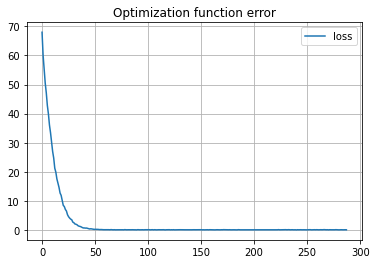

In [ ]:
plt.figure()
plt.plot(ls_loss,label="loss")
plt.title('Optimization function error') # 最適化関数の誤差
plt.legend()
plt.grid()

## できあがったmodelでテストを行ってみる

In [ ]:
testset = Dataset( X_test , y_test )
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size = 1, shuffle=True)

In [ ]:
dataiter = iter(dataloader)

X, labal = dataiter.next()

## モデルで計算した結果とラベルを比較するために、numpy flatに入れ込む

In [ ]:

y_testresult = np.array([])
com_label = np.array([])
model.eval()


for i, (X, label) in enumerate(dataloader):

    optimizer.zero_grad()
    
    y = model(X)
    l = label

    #print("label",label)
    #print(y)

    y = y.to('cpu').detach().numpy().copy()
    l = l.to('cpu').detach().numpy().copy()

    y_testresult = np.append(y_testresult,y)
    com_label = np.append(com_label,l)


## 結果を可視化する。 

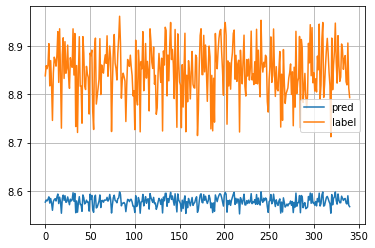

In [ ]:
plt.figure()
plt.plot(y_testresult,label="pred")
plt.plot(com_label,label="label")
plt.legend()
plt.grid()

# 対数変換を行って学習したため、指数変換し元に戻す

In [ ]:
exp_y_testresult = np.exp(y_testresult)
exp_com_label = np.exp(com_label)

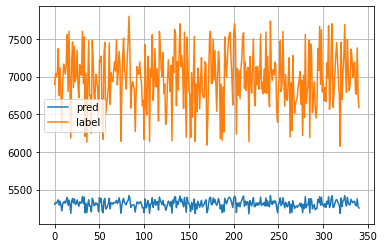

In [ ]:
plt.figure()
plt.plot(exp_y_testresult,label="pred")
plt.plot(exp_com_label,label="label")
plt.legend()
plt.grid()

# 結果は常に低く見積もってしまっているが、トレンドはつかめている？？
# 一部分だけを切り取ってグラフを拡大する
randomで幅25を確認する

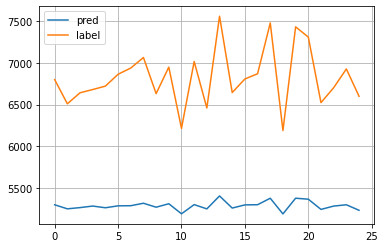

In [ ]:
from numpy.random import *


scope_size = 25

len_ = len(y_testresult)
random_scope = len_ - scope_size

rand_start = randint(random_scope)

rand_pred = exp_y_testresult[rand_start:rand_start+scope_size]
rand_label = exp_com_label[rand_start:rand_start+scope_size]

plt.figure()
plt.plot(rand_pred,label="pred")
plt.plot(rand_label,label="label")
plt.legend()
plt.grid()


## 出来上がったモデルを保存する

In [ ]:
torch.save(model.state_dict(), 'StockRegression.ckpt')

In [ ]:
model_from_SavePoint = Predictor(input_dim,64,1).to(device)
model_from_SavePoint.load_state_dict(torch.load('StockRegression.ckpt'))

<All keys matched successfully>